## **Summary from outlier**

1. headshotrate > 0.5
2. damagedealt >= 4000
3. kills > 60
4. killstreak > 10
5. walkdistance > 7.5k
6. weaponacquired > 20
7. heals > 40
8. boosts > 20
9. totaldistance == 0 & kills > 0
10. walkdistance == 0 & kills > 0
11. ridedistance == 0 & roadkills > 0
12. weaponacquired == 0 & winplaceperc > 0.5
13. heals == 0 & winplaceperc > 0.8
14. heals and boosts == 0 & winplaceperc > 0.8
15. one NaN in target value

In [1]:
import os, time, gc
import pandas as pd, numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
os.listdir('input')

['sample_submission_V2.csv', 'test_V2.csv', 'train_V2.csv']

In [3]:
%%time
tr = pd.read_csv("input/train_V2.csv")
te = pd.read_csv("input/test_V2.csv")

Wall time: 11.9 s


In [4]:
def missing_values_table(df):# Function to calculate missing values by column# Funct 
    mis_val = df.isnull().sum() # Total missing values
    mis_val_pct = 100 * df.isnull().sum() / len(df)# Percentage of missing values
    mis_val_df = pd.concat([mis_val, mis_val_pct], axis=1)# Make a table with the results
    mis_val_df_cols = mis_val_df.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values'})# Rename the columns
    mis_val_df_cols = mis_val_df_cols[mis_val_df_cols.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(1)# Sort the table by percentage of missing descending
    print ("Dataframe has " + str(df.shape[1]) + " columns.\n" 
           "There are " + str(mis_val_df_cols.shape[0]) + " cols having missing values.")# Print some summary information
    return mis_val_df_cols # Return the dataframe with missing information

In [5]:
missing_values_table(tr)

Dataframe has 29 columns.
There are 1 cols having missing values.


,Missing Values,% of Total Values
winPlacePerc,1,0.0


In [6]:
missing_values_table(te)

Dataframe has 28 columns.
There are 0 cols having missing values.


,Missing Values,% of Total Values


In [7]:
tr[tr['winPlacePerc'].isnull()]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
2744604,f70c74418bb064,12dfbede33f92b,224a123c53e008,0,0,0.0,0,0,0,1,...,0,0.0,0,0.0,0,0,0.0,0,0,NaN


In [8]:
tr.drop(2744604, inplace=True)

In [9]:
def base(df):
    df['headshot_rate'] = df['headshotKills']/df['kills']
    df['total_distance'] = df[df.filter(regex='Dist').columns.tolist()].sum(axis=1)
    df['heals_n_boosts'] = df[['heals','boosts']].sum(axis=1)
    return df

In [10]:
tr = base(tr)
te = base(te)

In [11]:
tr['is_outlier'] = np.where(tr['headshot_rate']> 0.5, 1, 0)
tr['is_outlier'] = np.where(tr['damageDealt']>=4000, 1, 0)
tr['is_outlier'] = np.where(tr['kills']> 60, 1, 0)
tr['is_outlier'] = np.where(tr['killStreaks']> 10, 1, 0)
tr['is_outlier'] = np.where(tr['walkDistance']> 7500, 1, 0)
tr['is_outlier'] = np.where(tr['weaponsAcquired']> 20, 1, 0)
tr['is_outlier'] = np.where(tr['heals']> 40, 1, 0)
tr['is_outlier'] = np.where(tr['boosts']> 20, 1, 0)
tr['is_outlier'] = np.where((tr['total_distance']==0)&(tr['kills']!=0), 1, 0)
tr['is_outlier'] = np.where((tr['walkDistance']==0)&(tr['kills']!=0), 1, 0)
tr['is_outlier'] = np.where((tr['rideDistance']==0)&(tr['roadKills']!=0), 1, 0)
tr['is_outlier'] = np.where((tr['weaponsAcquired']==0)&(tr['winPlacePerc']>0.5), 1, 0)
tr['is_outlier'] = np.where((tr['heals']==0)&(tr['winPlacePerc']>0.8), 1, 0)
tr['is_outlier'] = np.where((tr['heals_n_boosts']==0)&(tr['winPlacePerc']>0.8), 1, 0)

In [12]:
print("The total number of outliers")
print("n = {}".format(tr['is_outlier'].sum()))
print("% = {}".format(tr['is_outlier'].sum()/tr.shape[0]))

The total number of outliers
n = 81343
% = 0.01829180126220917


# Build Model

**Train model w/o outliers**

In [13]:
print(tr.shape)
tr = tr[tr['is_outlier']==0]
print(tr.shape)

(4446965, 33)
(4365622, 33)


In [14]:
# exclude target and outlier columns
base_feat = tr.columns[3:-6].tolist()+tr.columns[29:-1].tolist()
train_Y = tr['winPlacePerc']

Make object type to category for lightgbm model to take.

In [15]:
tr[base_feat].dtypes.value_counts()

int64      19
float64     7
object      1
dtype: int64

In [16]:
tr[base_feat].select_dtypes(include=['object']).columns

Index(['matchType'], dtype='object')

In [17]:
tr['matchType'] = tr['matchType'].astype('category')
te['matchType'] = te['matchType'].astype('category')

Now object type changed to category

In [18]:
tr[base_feat].dtypes.value_counts()

int64       19
float64      7
category     1
dtype: int64

In [19]:
import time
from sklearn import metrics
from operator import itemgetter
import lightgbm as lgb

In [20]:
from sklearn.model_selection import train_test_split
def LGB_HOLDOUT_REG(size_ratio, train_X, test_X, metric, is_shuffle):
    X_tr,X_val,y_tr,y_val = train_test_split(train_X, train_Y, train_size = size_ratio, shuffle=is_shuffle)

    val_lgb = np.zeros(len(X_val))
    predictions = np.zeros(len(test_X))
    
    # Model parameters
    lgb_params = {'num_leaves': 31,
                 'min_data_in_leaf': 20, 
                 'objective':'regression',
                 'max_depth': -1,
                 'learning_rate': 0.1,
                 "boosting": "gbdt",
                 "feature_fraction": 1,
                 "bagging_freq": 1,
                 "bagging_fraction": 1,
                 "bagging_seed": 42,
                 "metric": metric,
                 "lambda_l1": 0.0,
                 "verbosity": 1000,
                 "nthread": -1,
                 "random_state": 42}

    model_start = time.time()

    model = lgb.LGBMRegressor(**lgb_params, n_estimators = 20000, n_jobs = -1)
    model.fit(X_tr, 
              y_tr, 
              eval_set=[(X_tr, y_tr), (X_val, y_val)], 
              eval_metric=metric,
              verbose=1000, 
              early_stopping_rounds=200)
    val_lgb = model.predict(X_val, num_iteration=model.best_iteration_)

    cv_score = model.best_score_

    #feature importance
    feature_importance_df = pd.DataFrame()
    feature_importance_df["Feature"] = train_X.columns
    feature_importance_df["importance"] = model.feature_importances_[:len(train_X.columns)]

    #predictions
    predictions = model.predict(test_X, num_iteration=model.best_iteration_)

    print("-" * 50)
    print("HOLD_OUT "+ metric + " = {}".format(cv_score))
    lgb.plot_metric(model, metric=metric, title='auc plot', xlabel='Iterations', ylabel='auto', figsize=(10,8), grid=False)

    model_end = time.time()
    model_elapsed = model_end - model_start
    print('Model elapsed {0:0.2f}'.format(model_elapsed/60), "minutes.")

    # FEATURE IMPORTANCE
    pd.set_option('display.max_rows', 500)
    feature_importance_df['Feature Rank'] = feature_importance_df['importance'].rank(ascending=0)
    feature_importance_df = feature_importance_df.sort_values('Feature Rank', ascending = True)
    print(feature_importance_df.loc[feature_importance_df['importance']!=0].head(100))

    return predictions, val_lgb, cv_score, feature_importance_df

Training until validation scores don't improve for 200 rounds
[1000]	training's l1: 0.0546671	valid_1's l1: 0.0550826
[2000]	training's l1: 0.0537909	valid_1's l1: 0.0545748
[3000]	training's l1: 0.053121	valid_1's l1: 0.0542379
[4000]	training's l1: 0.052565	valid_1's l1: 0.0540092
[5000]	training's l1: 0.052085	valid_1's l1: 0.0538539
[6000]	training's l1: 0.0516205	valid_1's l1: 0.0537041
[7000]	training's l1: 0.0512238	valid_1's l1: 0.0535996
[8000]	training's l1: 0.0508388	valid_1's l1: 0.0535069
[9000]	training's l1: 0.0504463	valid_1's l1: 0.0534107
[10000]	training's l1: 0.0500795	valid_1's l1: 0.0533297
[11000]	training's l1: 0.049726	valid_1's l1: 0.0532481
[12000]	training's l1: 0.0493972	valid_1's l1: 0.0532
[13000]	training's l1: 0.0490739	valid_1's l1: 0.053139
[14000]	training's l1: 0.0487602	valid_1's l1: 0.0530879
[15000]	training's l1: 0.0484536	valid_1's l1: 0.0530279
[16000]	training's l1: 0.0481482	valid_1's l1: 0.0529773
[17000]	training's l1: 0.0478565	valid_1's 

KeyError: 'No given metric in eval results.'

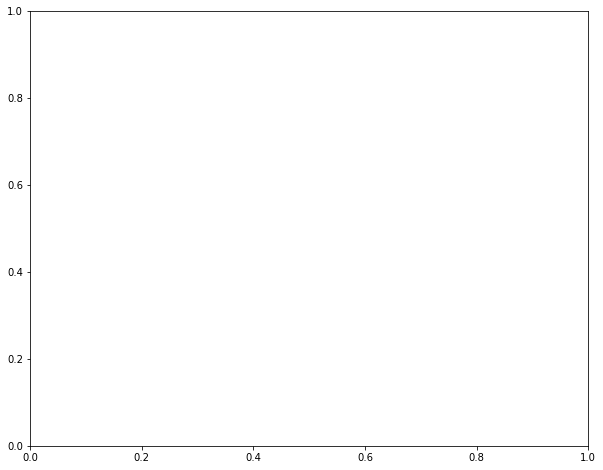

In [21]:
pred, val, cv, feat = LGB_HOLDOUT_REG(0.8, tr[base_feat], te[base_feat], 'l1', is_shuffle=True)